# KAN + SupCon + CenterLoss + Differentiable KShape on Trace Dataset

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
from tqdm import tqdm
import seaborn as sns
from scipy.optimize import linear_sum_assignment


In [2]:

def load_trace_dataset(train_path='Trace_TRAIN.tsv', test_path='Trace_TEST.tsv', normalize=True):
    train_data = np.loadtxt(train_path)
    test_data = np.loadtxt(test_path)
    X = np.concatenate([train_data[:, 1:], test_data[:, 1:]], axis=0)
    y = np.concatenate([train_data[:, 0], test_data[:, 0]], axis=0).astype(int)

    unique_labels = np.unique(y)
    label_map = {old: new for new, old in enumerate(unique_labels)}
    y = np.array([label_map[label] for label in y])

    if normalize:
        X = StandardScaler().fit_transform(X)
    return X, y

X, y = load_trace_dataset()
num_classes = len(np.unique(y))


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

sys.path.insert(0, './pykan_local/kan')  # 加入你本地pykan目录

from KANLayer_local import KANLayer # 来自你 pykan 文件夹

class KANEncoder(nn.Module):
    def __init__(self, input_dim=275, hidden_dim=128, output_dim=128):
        super().__init__()
        self.layer1 = KANLayer(in_dim=input_dim, out_dim=hidden_dim, num=21)
        self.layer2 = KANLayer(in_dim=hidden_dim, out_dim=hidden_dim, num=21)
        self.layer3 = KANLayer(in_dim=hidden_dim, out_dim=output_dim, num=21)

    def forward(self, x):
        x, _, _, _ = self.layer1(x)
        x, _, _, _ = self.layer2(x)
        x, _, _, _ = self.layer3(x)
        return F.normalize(x, dim=-1)

In [4]:

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, x, labels):
        return ((x - self.centers[labels])**2).sum() / 2.0

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        features = F.normalize(features, dim=1)
        sim_matrix = torch.matmul(features, features.T) / self.temperature
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float().to(device)
        logits_mask = torch.ones_like(mask) - torch.eye(features.shape[0], device=device)
        exp_sim = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-9)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1).clamp(min=1)
        return -mean_log_prob_pos.mean()

def differentiable_kshape_loss(features, labels, num_classes):
    loss = 0
    for c in range(num_classes):
        mask = labels == c
        if mask.sum() < 2:
            continue
        cluster_feat = features[mask]
        prototype = cluster_feat.mean(dim=0)
        aligned = F.cosine_similarity(cluster_feat, prototype.unsqueeze(0))
        loss += (1 - aligned).mean()
    return loss


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

encoder = KANEncoder(input_dim=X.shape[1], output_dim=128)
center_loss_fn = CenterLoss(num_classes=num_classes, feat_dim=128)
supcon_loss_fn = SupConLoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

epochs = 80
loss_history = []
ari_history = []
nmi_history = []

import copy
encoder_snapshots = {}  # 保存每10轮模型状态

for epoch in tqdm(range(epochs)):
    encoder.train()
    total_loss = 0

    for xb, yb in loader:
        optimizer.zero_grad()
        feats = encoder(xb)
        loss = (center_loss_fn(feats, yb) +
                supcon_loss_fn(feats, yb) +
                differentiable_kshape_loss(feats, yb, num_classes))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_history.append(total_loss)
    
    if epoch % 5 == 0 or epoch == epochs - 1:
        encoder_snapshots[epoch] = copy.deepcopy(encoder.state_dict())
    print(f"[Snapshot] Saved encoder at epoch {epoch}")


   # ===== ✅ 聚类评估指标 =====
    encoder.eval()
    with torch.no_grad():
        feats_all = encoder(X_tensor).cpu().numpy()
        true_labels = y_tensor.cpu().numpy()

    kmeans = KMeans(n_clusters=num_classes, n_init=20, random_state=42)
    pred_labels = kmeans.fit_predict(feats_all)

    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    sil = silhouette_score(feats_all, pred_labels)

    ari_history.append(ari)
    nmi_history.append(nmi)

    print(f"Epoch {epoch} | Loss: {total_loss:.4f} | ARI: {ari:.4f} | NMI: {nmi:.4f} | Silhouette: {sil:.4f}")

  0%|          | 0/80 [00:00<?, ?it/s]

[Snapshot] Saved encoder at epoch 0


  1%|▏         | 1/80 [00:00<01:03,  1.24it/s]

Epoch 0 | Loss: 11031.0760 | ARI: 0.6054 | NMI: 0.6964 | Silhouette: 0.4467
[Snapshot] Saved encoder at epoch 1


  2%|▎         | 2/80 [00:01<01:02,  1.25it/s]

Epoch 1 | Loss: 10408.7879 | ARI: 0.6695 | NMI: 0.7584 | Silhouette: 0.5836
[Snapshot] Saved encoder at epoch 2


  4%|▍         | 3/80 [00:02<01:02,  1.24it/s]

Epoch 2 | Loss: 10255.5058 | ARI: 0.6912 | NMI: 0.7804 | Silhouette: 0.6192
[Snapshot] Saved encoder at epoch 3


  5%|▌         | 4/80 [00:03<01:03,  1.19it/s]

Epoch 3 | Loss: 10189.2413 | ARI: 0.7585 | NMI: 0.8223 | Silhouette: 0.6230


  6%|▋         | 5/80 [00:04<01:02,  1.21it/s]

[Snapshot] Saved encoder at epoch 4
Epoch 4 | Loss: 10143.0144 | ARI: 0.9606 | NMI: 0.9587 | Silhouette: 0.7314


  8%|▊         | 6/80 [00:04<01:00,  1.22it/s]

[Snapshot] Saved encoder at epoch 5
Epoch 5 | Loss: 10064.5104 | ARI: 0.9606 | NMI: 0.9587 | Silhouette: 0.8279
[Snapshot] Saved encoder at epoch 6


  9%|▉         | 7/80 [00:05<01:01,  1.18it/s]

Epoch 6 | Loss: 9952.1053 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.8844
[Snapshot] Saved encoder at epoch 7


 10%|█         | 8/80 [00:06<00:59,  1.21it/s]

Epoch 7 | Loss: 9902.6657 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.8989


 11%|█▏        | 9/80 [00:07<00:55,  1.27it/s]

[Snapshot] Saved encoder at epoch 8
Epoch 8 | Loss: 9894.1151 | ARI: 0.9866 | NMI: 0.9823 | Silhouette: 0.9074
[Snapshot] Saved encoder at epoch 9


 12%|█▎        | 10/80 [00:08<00:57,  1.21it/s]

Epoch 9 | Loss: 9898.1552 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9287
[Snapshot] Saved encoder at epoch 10


 14%|█▍        | 11/80 [00:08<00:54,  1.27it/s]

Epoch 10 | Loss: 9888.0991 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9363


 15%|█▌        | 12/80 [00:09<00:51,  1.31it/s]

[Snapshot] Saved encoder at epoch 11
Epoch 11 | Loss: 9882.5780 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9456


 16%|█▋        | 13/80 [00:10<00:51,  1.30it/s]

[Snapshot] Saved encoder at epoch 12
Epoch 12 | Loss: 9878.2430 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9529


 18%|█▊        | 14/80 [00:11<00:51,  1.28it/s]

[Snapshot] Saved encoder at epoch 13
Epoch 13 | Loss: 9877.9272 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9596
[Snapshot] Saved encoder at epoch 14


 19%|█▉        | 15/80 [00:12<00:51,  1.27it/s]

Epoch 14 | Loss: 9877.0860 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9637


 20%|██        | 16/80 [00:12<00:48,  1.31it/s]

[Snapshot] Saved encoder at epoch 15
Epoch 15 | Loss: 9878.2421 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9672
[Snapshot] Saved encoder at epoch 16


 21%|██▏       | 17/80 [00:13<00:48,  1.29it/s]

Epoch 16 | Loss: 9877.8068 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9698


 22%|██▎       | 18/80 [00:14<00:46,  1.33it/s]

[Snapshot] Saved encoder at epoch 17
Epoch 17 | Loss: 9877.7152 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9719


 24%|██▍       | 19/80 [00:15<00:46,  1.30it/s]

[Snapshot] Saved encoder at epoch 18
Epoch 18 | Loss: 9875.0118 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9738
[Snapshot] Saved encoder at epoch 19


 25%|██▌       | 20/80 [00:15<00:48,  1.25it/s]

Epoch 19 | Loss: 9877.4370 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9751
[Snapshot] Saved encoder at epoch 20


 26%|██▋       | 21/80 [00:16<00:47,  1.24it/s]

Epoch 20 | Loss: 9875.6927 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9764
[Snapshot] Saved encoder at epoch 21


 28%|██▊       | 22/80 [00:17<00:50,  1.16it/s]

Epoch 21 | Loss: 9875.6713 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9775


 29%|██▉       | 23/80 [00:18<00:48,  1.19it/s]

[Snapshot] Saved encoder at epoch 22
Epoch 22 | Loss: 9877.1830 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9785
[Snapshot] Saved encoder at epoch 23


 30%|███       | 24/80 [00:19<00:48,  1.16it/s]

Epoch 23 | Loss: 9875.6081 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9794


 31%|███▏      | 25/80 [00:20<00:46,  1.19it/s]

[Snapshot] Saved encoder at epoch 24
Epoch 24 | Loss: 9875.5715 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9802
[Snapshot] Saved encoder at epoch 25


 32%|███▎      | 26/80 [00:21<00:44,  1.20it/s]

Epoch 25 | Loss: 9874.5119 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9810
[Snapshot] Saved encoder at epoch 26


 34%|███▍      | 27/80 [00:21<00:44,  1.18it/s]

Epoch 26 | Loss: 9875.6864 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9815
[Snapshot] Saved encoder at epoch 27


 35%|███▌      | 28/80 [00:22<00:43,  1.19it/s]

Epoch 27 | Loss: 9874.4110 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9822


 36%|███▋      | 29/80 [00:23<00:43,  1.17it/s]

[Snapshot] Saved encoder at epoch 28
Epoch 28 | Loss: 9875.4509 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9827
[Snapshot] Saved encoder at epoch 29


 38%|███▊      | 30/80 [00:24<00:42,  1.19it/s]

Epoch 29 | Loss: 9875.9354 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9833
[Snapshot] Saved encoder at epoch 30


 39%|███▉      | 31/80 [00:25<00:43,  1.13it/s]

Epoch 30 | Loss: 9876.0887 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9839
[Snapshot] Saved encoder at epoch 31


 40%|████      | 32/80 [00:26<00:41,  1.16it/s]

Epoch 31 | Loss: 9874.4702 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9844
[Snapshot] Saved encoder at epoch 32


 41%|████▏     | 33/80 [00:27<00:42,  1.11it/s]

Epoch 32 | Loss: 9877.0244 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9847
[Snapshot] Saved encoder at epoch 33


 42%|████▎     | 34/80 [00:28<00:40,  1.14it/s]

Epoch 33 | Loss: 9875.3472 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9854
[Snapshot] Saved encoder at epoch 34


 44%|████▍     | 35/80 [00:28<00:39,  1.14it/s]

Epoch 34 | Loss: 9874.3366 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9858
[Snapshot] Saved encoder at epoch 35


 45%|████▌     | 36/80 [00:29<00:37,  1.16it/s]

Epoch 35 | Loss: 9874.3281 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9861
[Snapshot] Saved encoder at epoch 36


 46%|████▋     | 37/80 [00:30<00:36,  1.19it/s]

Epoch 36 | Loss: 9874.3497 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9863
[Snapshot] Saved encoder at epoch 37


 48%|████▊     | 38/80 [00:31<00:35,  1.17it/s]

Epoch 37 | Loss: 9875.3864 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9866
[Snapshot] Saved encoder at epoch 38


 49%|████▉     | 39/80 [00:32<00:34,  1.20it/s]

Epoch 38 | Loss: 9876.9915 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9870
[Snapshot] Saved encoder at epoch 39


 50%|█████     | 40/80 [00:33<00:33,  1.21it/s]

Epoch 39 | Loss: 9874.0211 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9875
[Snapshot] Saved encoder at epoch 40


 51%|█████▏    | 41/80 [00:33<00:32,  1.22it/s]

Epoch 40 | Loss: 9874.1129 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9877
[Snapshot] Saved encoder at epoch 41


 52%|█████▎    | 42/80 [00:34<00:31,  1.19it/s]

Epoch 41 | Loss: 9873.1531 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9879
[Snapshot] Saved encoder at epoch 42


 54%|█████▍    | 43/80 [00:35<00:30,  1.21it/s]

Epoch 42 | Loss: 9876.3950 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9880
[Snapshot] Saved encoder at epoch 43


 55%|█████▌    | 44/80 [00:36<00:30,  1.17it/s]

Epoch 43 | Loss: 9876.4391 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9886
[Snapshot] Saved encoder at epoch 44


 56%|█████▋    | 45/80 [00:37<00:29,  1.20it/s]

Epoch 44 | Loss: 9874.3997 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9890
[Snapshot] Saved encoder at epoch 45


 57%|█████▊    | 46/80 [00:38<00:29,  1.17it/s]

Epoch 45 | Loss: 9875.9298 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9890
[Snapshot] Saved encoder at epoch 46


 59%|█████▉    | 47/80 [00:39<00:28,  1.15it/s]

Epoch 46 | Loss: 9874.3716 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9893
[Snapshot] Saved encoder at epoch 47


 60%|██████    | 48/80 [00:39<00:27,  1.18it/s]

Epoch 47 | Loss: 9874.1201 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9895
[Snapshot] Saved encoder at epoch 48


 61%|██████▏   | 49/80 [00:40<00:26,  1.15it/s]

Epoch 48 | Loss: 9875.3744 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9896
[Snapshot] Saved encoder at epoch 49


 62%|██████▎   | 50/80 [00:41<00:28,  1.04it/s]

Epoch 49 | Loss: 9874.1212 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9898


 64%|██████▍   | 51/80 [00:42<00:26,  1.09it/s]

[Snapshot] Saved encoder at epoch 50
Epoch 50 | Loss: 9876.8715 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9897
[Snapshot] Saved encoder at epoch 51


 65%|██████▌   | 52/80 [00:43<00:25,  1.09it/s]

Epoch 51 | Loss: 9875.7515 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9902
[Snapshot] Saved encoder at epoch 52


 66%|██████▋   | 53/80 [00:44<00:23,  1.14it/s]

Epoch 52 | Loss: 9875.7999 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9903


 68%|██████▊   | 54/80 [00:45<00:22,  1.13it/s]

[Snapshot] Saved encoder at epoch 53
Epoch 53 | Loss: 9874.3204 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9904
[Snapshot] Saved encoder at epoch 54


 69%|██████▉   | 55/80 [00:46<00:21,  1.17it/s]

Epoch 54 | Loss: 9874.3793 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9903
[Snapshot] Saved encoder at epoch 55


 70%|███████   | 56/80 [00:47<00:20,  1.14it/s]

Epoch 55 | Loss: 9874.1052 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9907
[Snapshot] Saved encoder at epoch 56


 71%|███████▏  | 57/80 [00:47<00:20,  1.14it/s]

Epoch 56 | Loss: 9876.7781 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9908
[Snapshot] Saved encoder at epoch 57


 72%|███████▎  | 58/80 [00:48<00:19,  1.13it/s]

Epoch 57 | Loss: 9876.7950 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9912
[Snapshot] Saved encoder at epoch 58


 74%|███████▍  | 59/80 [00:49<00:19,  1.09it/s]

Epoch 58 | Loss: 9875.8020 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9916
[Snapshot] Saved encoder at epoch 59


 75%|███████▌  | 60/80 [00:50<00:17,  1.13it/s]

Epoch 59 | Loss: 9875.1234 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9918


 76%|███████▋  | 61/80 [00:51<00:16,  1.16it/s]

[Snapshot] Saved encoder at epoch 60
Epoch 60 | Loss: 9876.7987 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9918


 78%|███████▊  | 62/80 [00:52<00:15,  1.15it/s]

[Snapshot] Saved encoder at epoch 61
Epoch 61 | Loss: 9875.0612 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9921


 79%|███████▉  | 63/80 [00:53<00:14,  1.17it/s]

[Snapshot] Saved encoder at epoch 62
Epoch 62 | Loss: 9874.0583 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9919


 80%|████████  | 64/80 [00:54<00:13,  1.16it/s]

[Snapshot] Saved encoder at epoch 63
Epoch 63 | Loss: 9876.2492 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9919
[Snapshot] Saved encoder at epoch 64


 81%|████████▏ | 65/80 [00:54<00:12,  1.18it/s]

Epoch 64 | Loss: 9876.9510 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9923
[Snapshot] Saved encoder at epoch 65


 82%|████████▎ | 66/80 [00:55<00:12,  1.16it/s]

Epoch 65 | Loss: 9876.8469 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9927
[Snapshot] Saved encoder at epoch 66


 84%|████████▍ | 67/80 [00:56<00:11,  1.15it/s]

Epoch 66 | Loss: 9876.2013 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9930
[Snapshot] Saved encoder at epoch 67


 85%|████████▌ | 68/80 [00:57<00:10,  1.14it/s]

Epoch 67 | Loss: 9876.3315 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9932
[Snapshot] Saved encoder at epoch 68


 86%|████████▋ | 69/80 [00:58<00:09,  1.13it/s]

Epoch 68 | Loss: 9876.7845 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9934
[Snapshot] Saved encoder at epoch 69


 88%|████████▊ | 70/80 [00:59<00:08,  1.16it/s]

Epoch 69 | Loss: 9875.7851 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9935
[Snapshot] Saved encoder at epoch 70


 89%|████████▉ | 71/80 [01:00<00:07,  1.15it/s]

Epoch 70 | Loss: 9874.0349 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9929
[Snapshot] Saved encoder at epoch 71


 90%|█████████ | 72/80 [01:00<00:06,  1.17it/s]

Epoch 71 | Loss: 9876.7812 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9925
[Snapshot] Saved encoder at epoch 72


 91%|█████████▏| 73/80 [01:01<00:06,  1.08it/s]

Epoch 72 | Loss: 9875.1794 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9928
[Snapshot] Saved encoder at epoch 73


 92%|█████████▎| 74/80 [01:02<00:05,  1.13it/s]

Epoch 73 | Loss: 9873.0381 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9930


 94%|█████████▍| 75/80 [01:03<00:04,  1.16it/s]

[Snapshot] Saved encoder at epoch 74
Epoch 74 | Loss: 9876.8665 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9919
[Snapshot] Saved encoder at epoch 75


 95%|█████████▌| 76/80 [01:04<00:03,  1.18it/s]

Epoch 75 | Loss: 9874.1130 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9923
[Snapshot] Saved encoder at epoch 76


 96%|█████████▋| 77/80 [01:05<00:02,  1.16it/s]

Epoch 76 | Loss: 9876.9449 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9921
[Snapshot] Saved encoder at epoch 77


 98%|█████████▊| 78/80 [01:06<00:01,  1.14it/s]

Epoch 77 | Loss: 9875.1695 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9927
[Snapshot] Saved encoder at epoch 78


 99%|█████████▉| 79/80 [01:07<00:00,  1.17it/s]

Epoch 78 | Loss: 9875.1536 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9931
[Snapshot] Saved encoder at epoch 79


100%|██████████| 80/80 [01:07<00:00,  1.18it/s]

Epoch 79 | Loss: 9875.2375 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9933


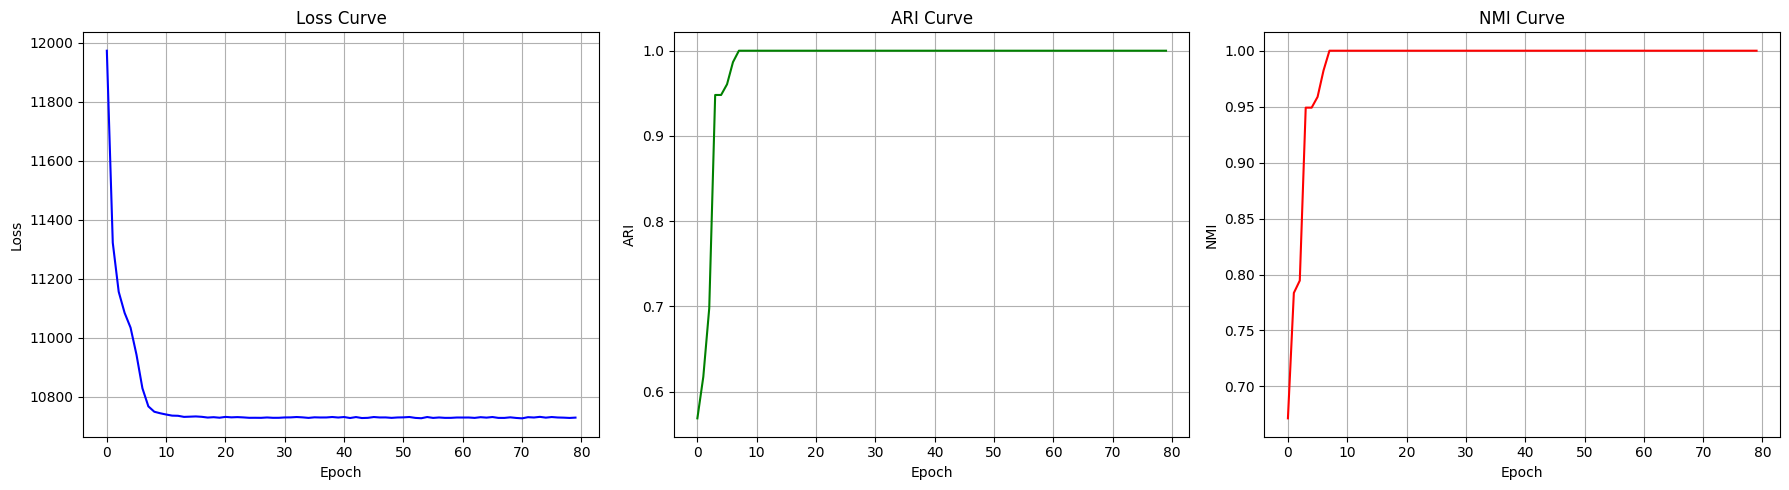

In [6]:
# ===== 📈 可视化 Loss / ARI / NMI 曲线 =====
epochs_range = range(len(loss_history))

# 创建横向排列的三个子图
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

axs[0].plot(epochs_range, loss_history, label='Loss', color='blue')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

axs[1].plot(epochs_range, ari_history, label='ARI', color='green')
axs[1].set_title('ARI Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ARI')
axs[1].grid(True)

axs[2].plot(epochs_range, nmi_history, label='NMI', color='red')
axs[2].set_title('NMI Curve')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('NMI')
axs[2].grid(True)
plt.tight_layout()

svg_path = "./metrics_over_epochs1.svg"
plt.savefig(svg_path, format='svg')
plt.show()

In [7]:

@torch.no_grad()
def evaluate_clustering(encoder, X_tensor, y_true, num_classes):
    encoder.eval()
    feats = encoder(X_tensor).cpu().numpy()
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=num_classes, random_state=42).fit(feats)
    pred = km.labels_

    # Hungarian matching
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    pred_aligned = np.array([mapping[p] for p in pred])

    ari = adjusted_rand_score(y_true, pred_aligned)
    nmi = normalized_mutual_info_score(y_true, pred_aligned)
    sil = silhouette_score(feats, y_true)
    print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}, Silhouette: {sil:.4f}")
    return feats, pred_aligned

feats, pred = evaluate_clustering(encoder, X_tensor, y, num_classes)


ARI: 1.0000, NMI: 1.0000, Silhouette: 0.9933


In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

def plot_selected_epochs_3D_snapshots(encoder_snapshots, encoder, X_tensor, y_tensor, num_classes, save_path=None):
    selected_epochs = [0, 5, 10, 15]
    fig = plt.figure(figsize=(20, 5))

    for idx, epoch in enumerate(selected_epochs):
        if epoch not in encoder_snapshots:
            continue

        encoder.load_state_dict(encoder_snapshots[epoch])
        encoder.eval()
        with torch.no_grad():
            feats_all = encoder(X_tensor).cpu().numpy()

        kmeans = KMeans(n_clusters=num_classes, random_state=42)
        pred_labels = kmeans.fit_predict(feats_all)

        ax = fig.add_subplot(1, 4, idx + 1, projection='3d')
        ax.scatter(feats_all[:, 0], feats_all[:, 1], feats_all[:, 2],
                   c=pred_labels, cmap='tab10', alpha=0.8)
        ax.set_title(f"Epoch {epoch}")
        ax.set_xlabel("F1")
        ax.set_ylabel("F2")
        ax.set_zlabel("F3")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='svg')  # 可改为 'png'、'pdf'、'jpg'
        print(f"✅ 图像已保存为：{save_path}")

    plt.show()




✅ 图像已保存为：cluster_snapshots.svg


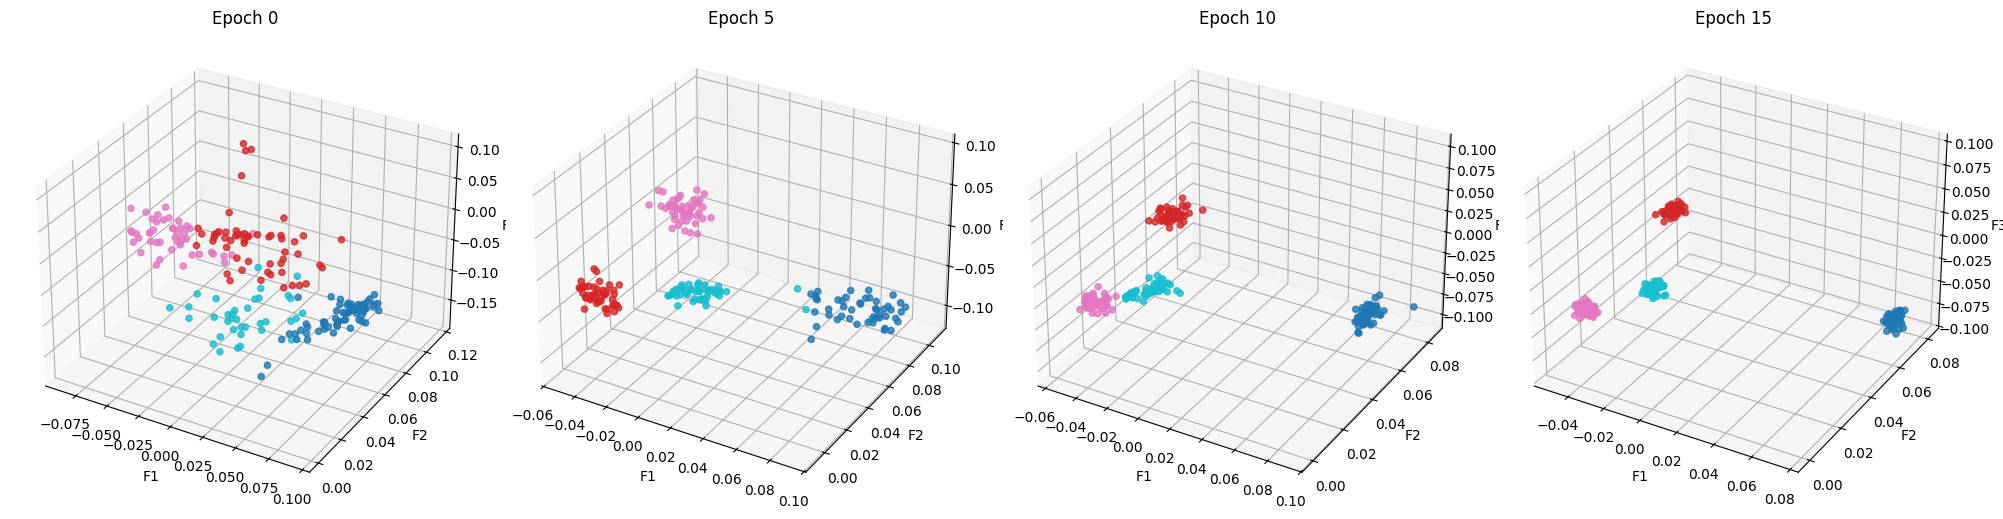

In [29]:
plot_selected_epochs_3D_snapshots(
    encoder_snapshots,
    encoder,
    X_tensor,
    y_tensor,
    num_classes=4,
    save_path="cluster_snapshots.svg"  # 改为你想保存的路径
)


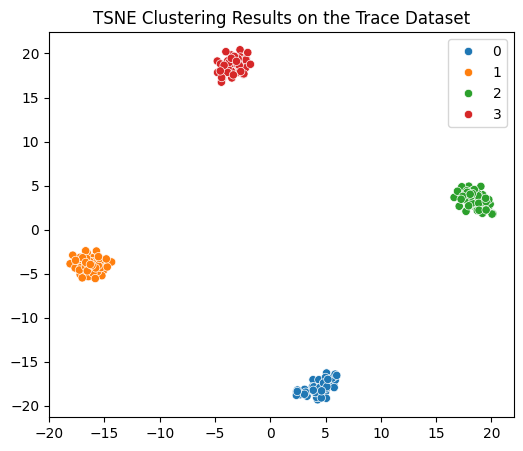

In [8]:

tsne = TSNE(n_components=2)
vis = tsne.fit_transform(feats)
plt.figure(figsize=(6,5))
sns.scatterplot(x=vis[:,0], y=vis[:,1], hue=pred, palette='tab10')
plt.title("TSNE Clustering Results on the Trace Dataset")
svg_path = "./1.svg"
plt.savefig(svg_path, format='svg')
plt.show()



In [12]:
acc = clustering_accuracy(true_labels, pred_labels)
print(f"Clustering Accuracy (ACC): {acc:.4f}")


Clustering Accuracy (ACC): 1.0000
